In [4]:
import sys
import os

!git clone https://github.com/mv-lab/InstructIR.git
sys.path.append("InstructIR/")

Cloning into 'InstructIR'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 147 (delta 31), reused 107 (delta 19), pack-reused 24
Receiving objects: 100% (147/147), 89.28 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [5]:
os.chdir("InstructIR/")
!ls

LICENSE                 data                    predict.py
README.md               demo.ipynb              requirements_gradio.txt
app.py                  images                  static
cog.yaml                index.html              text
configs                 models                  utils.py


In [8]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.3 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 3.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 7.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 8.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 8.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import imageio.v3 as iio
from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/arinsrini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arinsrini/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
CONFIG     = "configs/eval5d.yml"
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

In [26]:
!ls models/

im_instructir-7d.pt lm_instructir-7d.pt nafnet_utils.py
instructir.py       nafnet.py


In [27]:
print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
cpu
IMAGE MODEL CKPT: models/im_instructir-7d.pt
Loaded weights! 15.843363


In [28]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head #.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

tokenizer_config.json: 100%|██████████| 1.56k/1.56k [00:00<00:00, 823kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 7.20MB/s]
tokenizer.json: 100%|██████████| 712k/712k [00:00<00:00, 1.53MB/s]
added_tokens.json: 100%|██████████| 82.0/82.0 [00:00<00:00, 94.4kB/s]
config.json: 100%|██████████| 745/745 [00:00<00:00, 1.30MB/s]
pytorch_model.bin: 100%|██████████| 34.8M/34.8M [00:04<00:00, 7.68MB/s]

LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


In [29]:
def process_img (image, prompt):
    """
    Given an image and a prompt, we run the model to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd #.to(device)
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


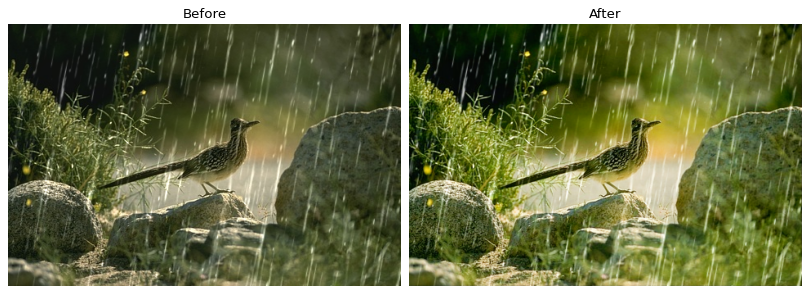

In [30]:
IMG    = "images/rain-020.png"
PROMPT = "Retouch the picture as a professional photographer please"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

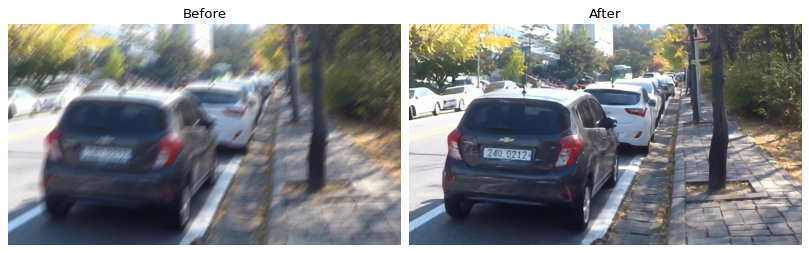

In [31]:
IMG    = "images/gopro.png"
PROMPT = "I was running, please stabilize this image"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

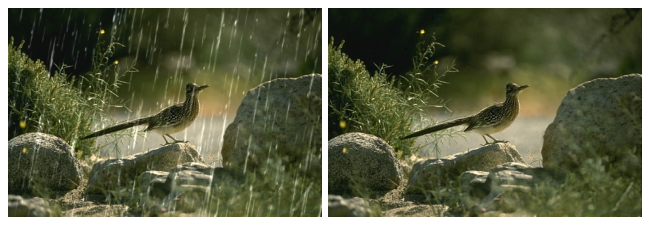

In [32]:
IMG    = "images/rain-020.png"
image  = load_img(IMG)

PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

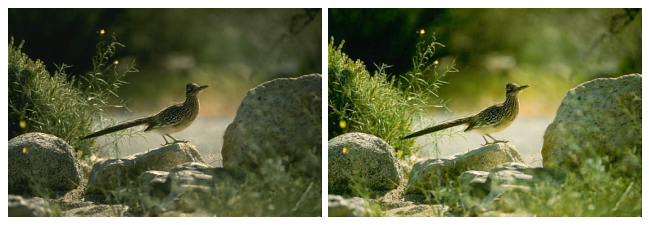

In [33]:
PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )
plot_all([result1, result2], figsize=(8,4))

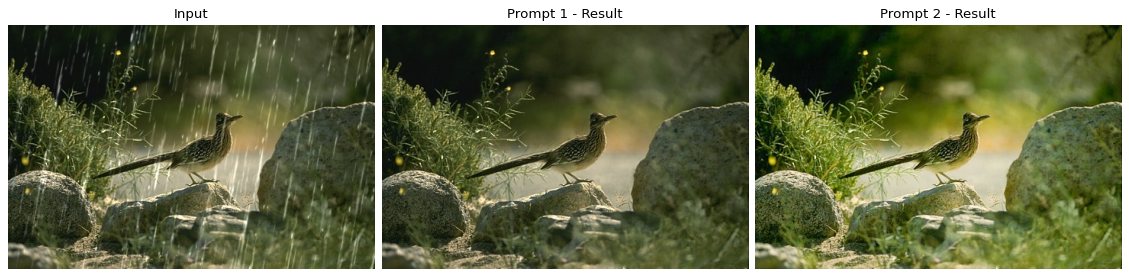

In [34]:
plot_all([image, result1, result2], names=["Input", "Prompt 1 - Result", "Prompt 2 - Result"], figsize=(14,7))

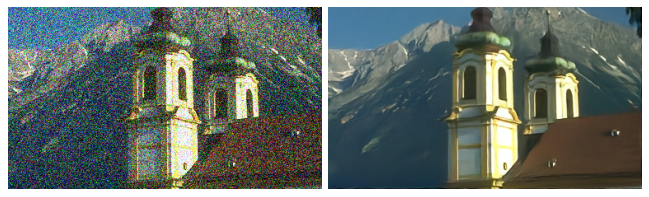

In [35]:
IMG    = "images/noise50.png"
image  = load_img(IMG)

PROMPT1 = "I love this photo, but there is too much noise, remove everything"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

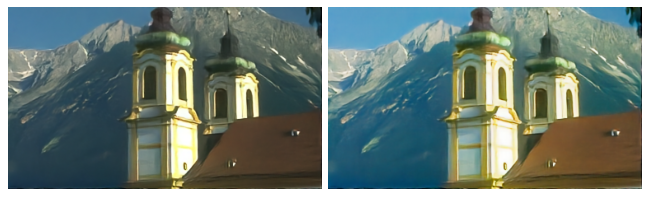

In [36]:
PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )
plot_all([result1, result2], figsize=(8,4))

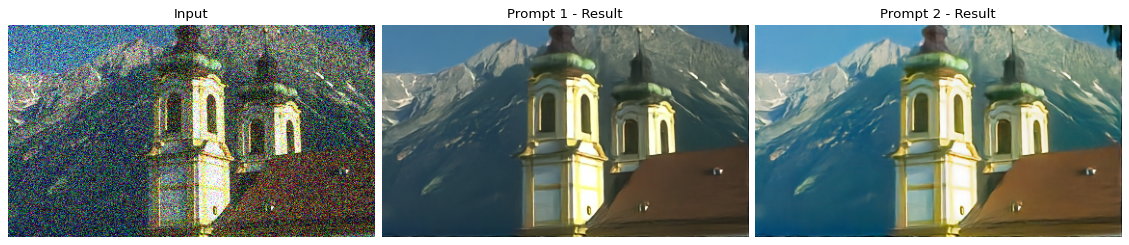

In [37]:
plot_all([image, result1, result2], names=["Input", "Prompt 1 - Result", "Prompt 2 - Result"], figsize=(14,7))